In [1]:
#pip install python-craigslist

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#Dependencies
from craigslist import CraigslistHousing
import timeit, os
from tqdm import tqdm
import pickle
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import time
import pandas as pd
import missingno
import re
import json
from pprint import pprint
from datetime import datetime, timedelta, timezone

from urls_list import * #where all urls and paths are saved
from config import *
from harvesine_distance import harvesine_distance

# Extract

###  Craigslist api call to extract the listing url and basic information

In [2]:
##Initially we scrape all 3000 in entire toronto. Then, we scrape on a daily posting basis from craiglist while building app
#https://toronto.craigslist.org/search/apa?bundleDuplicates=1&availabilityMode=0&sale_date=all+dates

In [3]:
def craigs_list_api_call():
    
    cl_tor_housing = CraigslistHousing(site='toronto',
                             filters={'bundle_duplicates': 1})

    #If geotagged=True, the results will include the (lat, lng) in the 'geotag' attrib (this will make the process a little bit longer).
    craiglist_housing = []

    start = timeit.timeit()
    for result in tqdm(cl_tor_housing.get_results(sort_by='newest', geotagged=True)):
        craiglist_housing.append(result)
    end = timeit.timeit()
    print(f"Time elapsed is {end - start}")
    return craiglist_housing

#craiglist_housing = craigs_list_api_call()

In [4]:
#with open(os.path.join('..','Stage','craiglist_housing.pkl'), 'wb') as f:
    #pickle.dump(craiglist_housing, f)

with open(os.path.join('..','Stage','craiglist_housing.pkl'), 'rb') as f:
    craiglist_housing = pickle.load(f)

###  Scraping the craigslist posting data using the urls obtained through API call

In [5]:
def instatiate_driver():
    #########################################################################################
    #Instatiate Selenium driver
    #Returns the handle object
    #########################################################################################
    chrome_options = webdriver.ChromeOptions()
    CHROMEDRIVER_PATH = executable_path
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--headless')
    driver = webdriver.Chrome(executable_path=CHROMEDRIVER_PATH, options=chrome_options)
    return driver

In [6]:
def craigs_list_scrape(craigs_list_post_docs):
    #Instatiate the selenium driver
    driver = instatiate_driver()
    error_list = []
    

    craigs_list_post_docs_cp = craigs_list_post_docs.copy()
    for post in tqdm(craigs_list_post_docs_cp):

        #Visit the url
        driver.get(post['url'])

        #Separate Try Except to handle each cases separately
        #Apartment feature(Some extra feature beside the title)
        try:
            apartment_feature = driver.find_element_by_css_selector('span[class="postingtitletext"] span[class="housing"]').text
        except:
            #print(post['id'])
            error_list.append({post['id']:'apartment_feature'})
            apartment_feature = None
        finally:
            post['apartment_feature'] = apartment_feature

        #First image if present   
        try:
            image = None
            if post['has_image']:
                image = driver.find_element_by_css_selector('div[class="gallery"]').find_element_by_css_selector('img').get_attribute('src')
        except:
            print(post['id'])
            error_list.append({post['id']:'image'})
        finally:
            post['has_image'] = image

        #Body of the post  
        try:
            posting = driver.find_element_by_id("postingbody").text
        except:
            print(post['id'])
            error_list.append({post['id']:'postingbody'})
            posting = None
        finally:
            post['posting'] = posting

        #Attributes      
        try:
            attributes = [elem.text for elem in driver.find_elements_by_css_selector('p[class="attrgroup"]  span')]
        except:
            print(post['id'])
            error_list.append({post['id']:'attributes'})
            attributes = []
        finally:
            post['attributes'] = attributes
            
        time.sleep(1)
            
    driver.quit()       
    return craigs_list_post_docs_cp
    

In [7]:
#craiglist_housing_enriched = craigs_list_scrape(craiglist_housing)

In [8]:
#with open(os.path.join('..','Stage','craiglist_housing_enriched.pkl'), 'wb') as f:
    #pickle.dump(craiglist_housing_enriched, f)

with open(os.path.join('..','Stage','craiglist_housing_enriched.pkl'), 'rb') as f:
    craiglist_renting_data = pickle.load(f)
    


---
---
---

### Check https://data.torontopolice.on.ca/datasets/mci-metadata/geoservice to see what input we need to give

In [9]:
id_value_dict = {row[1][0]:row[1][1] for row in pd.read_csv(os.path.join('..','Data','MCI_Metadata.csv'))[['ObjectId', 'Fields']].iterrows()}
value_id_dict = {id_value_dict[key]:key for key in id_value_dict}

`MCI Data` consists of assault, auto theft, break and enter, robbery and theft over
- We use `https://data.torontopolice.on.ca/datasets/mci-metadata/geoservice` to store all the data available (2014-2019) only

In [10]:
def batch_retrieve(arcgis_mci):
    #Takes url
    #API call
    #Gets response
    #Extract relevant info
    #Returns the no of records
    
    try:
        response = requests.get(arcgis_mci).json()
        records = [entry['attributes'] for entry in response['features']]

    except Exception as e:
        print("Arcgis mci url changed!")
    
    return records

def retrieve():
    #This function calls batch retrieve function with different URLs made with non-overlapping start - end date intervals
    #We have to do this because of the MCI data api behavious of providing only 2000 records at a time
    #The response is appended to a json file
    
    Data_DF = pd.DataFrame()
    
    
    start = datetime.fromisoformat('2014-01-01')
    while start < datetime.fromisoformat('2019-12-31') :
        end = start+timedelta(days=10) if start+timedelta(days=10) <= datetime.fromisoformat('2019-12-31') else datetime.fromisoformat('2019-12-31')
        start_date = start.strftime("%Y-%m-%d")
        end_date = end.strftime("%Y-%m-%d")
        arcgis_mci=f"https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/MCI_2014_to_2019/FeatureServer/0/query?where=reporteddate%20%3E%3D%20TIMESTAMP%20'{start_date}%2000%3A00%3A00'%20AND%20reporteddate%20%3C%3D%20TIMESTAMP%20'{end_date}%2000%3A00%3A00'&outFields=Index_,occurrencedate,reporteddate,premisetype,offence,MCI,Division,Neighbourhood,Long,Lat,reportedyear&returnGeometry=false&orderByFields=reporteddate ASC&outSR=&f=json"
        records = batch_retrieve(arcgis_mci)
        Data_DF=pd.concat([Data_DF, pd.DataFrame(records)])
        start = end+timedelta(days=1)
        
    return Data_DF


In [11]:
def retrieve_clean_MCI_data():
    #This function does the following
    #Call retrieve function to retrieve the MCI data to a DF
    #Date conversion and filter data(occurrencedate) from 2014 onwards only
    #Drop unnecessary col
    #Dump the clean data in a file
    #Returns clean data
    
    MCI_DF = retrieve()
    #Convert occurrencedate and reporteddate to the standard time format
    #Both are in UTC timestamp format which is the total millisec from 1970-01-01
    MCI_DF[['occurrencedate','reporteddate']] = MCI_DF[['occurrencedate','reporteddate']].apply(lambda x: [datetime.utcfromtimestamp(item//1000).strftime("%Y-%m-%d") for item in x])
    
    #Drop reportedyear as reporteddate is there
    MCI_DF.drop('reportedyear', axis=1, inplace=True)
    
    #filter data(occurrencedate) from 2014 onwards only
    MCI_DF = MCI_DF[MCI_DF['occurrencedate'].map(lambda x: datetime.strptime(x, "%Y-%m-%d")>=datetime.strptime('2014-01-01', "%Y-%m-%d"))]

    
    with open(os.path.join('..','Stage','MCI_toronto_data.pkl'), 'wb') as f:
        pickle.dump(MCI_DF,f)
    
    return MCI_DF

``MCI_DF = retrieve_clean_MCI_data()``

In [12]:
with open(os.path.join('..','Stage','MCI_toronto_data.pkl'), 'rb') as f:
    MCI_DF = pickle.load(f)

### This data doesn't include homicide. Hence, we need to include that separately

### Cleaning homicide data

In [13]:
def load_clean_homicide_data(csvpath):
    #This function does the following
    #retrive the file from the path to pandas DF
    #Rename the columns
    #Add columnns to match the MCI table
    #Date conversion and filter data from 2014 onwards only
    #Returns clean data
    
    homicide = pd.read_csv(csvpath)
    
    homicide.rename(columns={'Occurrence_Date':'occurrencedate',
       'Homicide_Type':'offence'}, inplace=True)

    #Choose only common and relevant columns
    homicide.drop(['Event_Unique_ID', 'Hood_ID', 'ObjectId', 'Occurrence_year'], inplace=True, axis=1)

    #Add new columns to homicide to be able to concatenate to MCI_DF
    homicide['premisetype'] = None
    homicide['reporteddate'] = None
    homicide['offence'] = 'Homicide'
    homicide['MCI'] = 'Homicide'

    #Date conversion from utc timestamp to the normal time
    homicide['occurrencedate'] = homicide['occurrencedate'].map(lambda x: datetime.utcfromtimestamp(x//1000).strftime("%Y-%m-%d"))  

    #As other crime data is from 2014 onwards, taking the same time period for homicide too
    homicide = homicide[homicide['occurrencedate'].map(lambda x: datetime.strptime(x, "%Y-%m-%d")>=datetime.strptime('2014-01-01', "%Y-%m-%d"))]   
    
    return homicide


homicide = load_clean_homicide_data(os.path.join('..','Data','Homicide.csv'))

### Combine both MIC-DF and homicide data and consider only from 2019  onwards



In [14]:
def make_crime_data(MCI_DF, homicide):
    #Concatenates both MCI data and homicide data
    #Take only from 2019  onwards
    #Sort the DF based on occurrencedate
    #Make a unique index for the crime data
    
    
    crime_data = pd.concat([MCI_DF, homicide])
    
    #Take only from 2018 onwards
    crime_data = crime_data[crime_data['occurrencedate'].map(lambda x: datetime.strptime(x, "%Y-%m-%d")>=datetime.strptime('2019-01-01', "%Y-%m-%d"))] 
    
    
    crime_data.sort_values('occurrencedate', inplace=True) 
    
    crime_data.drop('Index_', axis=1, inplace=True)
    crime_data.reset_index(drop=True, inplace=True)
    crime_data.reset_index(inplace=True)
    crime_data.rename(columns={'index':'ID'}, inplace=True)
    
    
    with open(os.path.join('..','Stage','crime_data.pkl'), 'wb') as f:
        pickle.dump(crime_data,f)
    
    return crime_data

``crime_data = make_crime_data(MCI_DF, homicide)``

In [15]:
with open(os.path.join('..','Stage','crime_data.pkl'), 'rb') as f:
    crime_data = pickle.load(f)

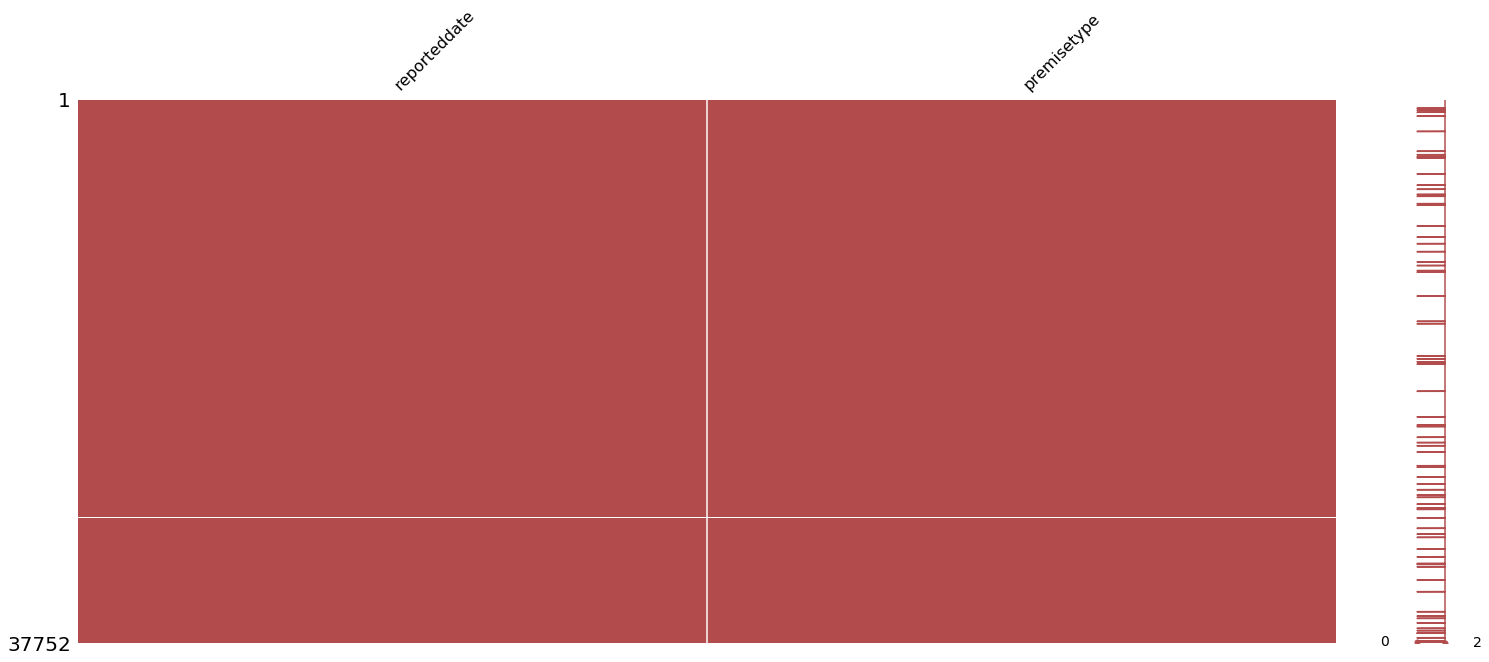

In [16]:
#Check for nan
missingdata_cols = crime_data.columns[crime_data.isnull().any()].to_list()
#visualize nan
_=missingno.matrix(crime_data[missingdata_cols], color=(0.7,0.3,0.3))

---
---
---

# Transform

### Initial form of data after scraping

In [17]:
DF = pd.DataFrame(craiglist_renting_data)
DF.head()

id   repost_of                                               name  \
0  7175656775        None  2 Bedrooms Apartment for Rent - 1350 Danforth ...   
1  7175641724  4905301368        ☎2 Room+Separate Reception @Etobicoke/Miss☎   
2  7175652366  7156890373                     87 Peter - Slate - 1bed Sept 1   
3  7175652126  7156846968  Harbour Plaza! 1Bed/1Bath +media area - September   
4  7175651860  6808310702                     The Eglinton / Redpath -studio   

                                                 url          datetime  \
0  https://toronto.craigslist.org/tor/apa/d/scarb...  2020-08-11 17:00   
1  https://toronto.craigslist.org/tor/off/d/2-roo...  2020-08-11 16:59   
2  https://toronto.craigslist.org/tor/apa/d/toron...  2020-08-11 16:53   
3  https://toronto.craigslist.org/tor/apa/d/toron...  2020-08-11 16:52   
4  https://toronto.craigslist.org/tor/apa/d/toron...  2020-08-11 16:52   

       last_updated   price               where  \
0  2020-08-11 17:00  $1,350  1350 Danforth Road   
1  2020-08-11 16:59  $1,599         Skymark Ave   
2  2020-08-11 16:53  $2,000            downtown   
3  2020-08-11 16:52  $2,250          Waterfront   
4  2020-08-11 16:52  $1,750     125 Redpath Ave   

                                           has_image                   geotag  \
0  https://images.craigslist.org/00F0F_l6VTmsBVGh...      (43.7464, -79.2323)   
1  https://images.craigslist.org/00q0q_hhCvFpP61t...  (43.663625, -79.593099)   
2  https://images.craigslist.org/01212_1tx3p0rlYW...  (43.646603, -79.392271)   
3  https://images.craigslist.org/00Q0Q_huAI9VgN8a...  (43.641093, -79.380324)   
4  https://images.craigslist.org/00J0J_3SYJ5EqHxl...  (43.707766, -79.392611)   

   deleted apartment_feature  \
0    False           / 2br -   
1    False              None   
2    False  / 1br - 538ft2 -   
3    False  / 1br - 595ft2 -   
4    False  / 1br - 359ft2 -   

                                             posting  \
0  Please view our available units by clicking on...   
1  *SPECIAL OFFER - $200 off the monthly rent for...   
2  87 Peter St –#3311 Slate – 1bed/1bath - 538 Sq...   
3  $2250 - 88 Harbour #2405 – 1Bed/1Bath (media a...   
4  The Eglinton- Maxwell #2711 -359 SqFt Studio $...   

                                          attributes  
0  [2BR / 1Ba, cats are OK - purrr, dogs are OK -...  
1                                                 []  
2  [1BR / 1Ba, 538ft2, available sep 1, cats are ...  
3  [1BR / 1Ba, 595ft2, available sep 1, condo, w/...  
4  [1BR / 2Ba, 359ft2, available aug 14, condo, w...

### Remove Duplicates and unreliable data
- All duplicated data are removed
- Dont consider empty postings
- Drop all those rows which don't have both 'geotag' and 'where'

In [18]:
## Check for duplicates in the dataset

In [19]:
duplicates = DF[DF.duplicated(DF.columns[:-1], keep=False)] #Duplicates cannot hash list
DF.drop_duplicates(subset=DF.columns[:-1], keep="first", inplace=True)
#Now id is unique
DF[DF.duplicated(DF.columns[0], keep=False)]


Empty DataFrame
Columns: [id, repost_of, name, url, datetime, last_updated, price, where, has_image, geotag, deleted, apartment_feature, posting, attributes]
Index: []

(21, 14)

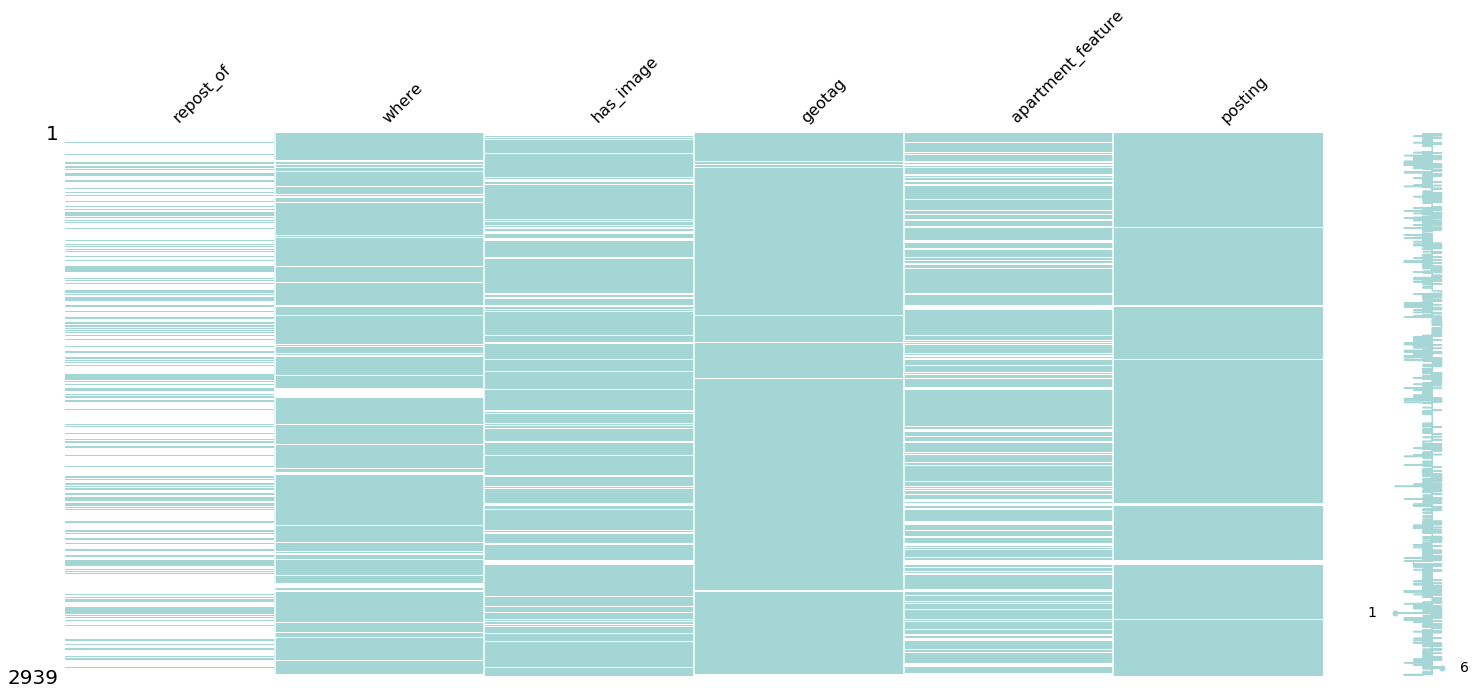

In [20]:
#Check for nan
missingdata_cols = DF.columns[DF.isnull().any()].to_list()
#visualize nan
_=missingno.matrix(DF[missingdata_cols], color=(0.65,0.84,0.84))
#Dont consider empty postings
DF.dropna(subset=['posting'], inplace=True)

#Location:- Coming to whereabouts, in most of the cases, we have geotag. Some of the cases which doesn't have geotag,
#we have "where". Check below.
DF[DF[['geotag', 'where']].apply(lambda x: (x['where'] is not None) and  (x['geotag'] is None) , axis=1)].shape
#We need to drop all those rows which don't have both
DF.dropna(subset=['where', 'geotag'], how='all', inplace=True)

## Deive new Features
- Combine the "attributes", "apartment_feature", "posting" together as "text" column for string search using regex to derive new features
- New features derived are
    - sf - Square Feet : (int or None) Based on ft2|SqFt in the text data
    - br - Bed Room: (float or None) Number of bedrooms, based on what is preceding BR 
    - ba - Bath: (float or None) Number of bath, based on what is preceding Ba
    - cats_allowed - True or False, based on the presence of 'cats are OK - purrr'
    - dogs are OK - wooof - True or False, based on the presence of 'dogs are OK - wooof'
    - Type - Type of the housing 1 out of ``['condo', 'house', 'apartment', 'suite', 'townhouse', 'loft', 'duplex',
       'flat', 'cottage', 'land']`` or ``None``
    - furnished - True/Flase/None - based on the presense of (un|non)(-) furnished strings or nothing
    

```unique_attributes = set()
for entry in DF['attributes']:
    unique_attributes = unique_attributes.union(set(entry))
unique_attributes```  

In [21]:
#Convert list to string
DF['attributes'] = DF['attributes'].map(lambda x: ' '.join(x))
#Convert the apartment feature none to ''(string)
DF['apartment_feature'].fillna(value=' ', inplace=True)#A string val
#Combine the "attributes", "apartment_feature", "posting" together as "text" column
DF["text"] = DF.apply(lambda x: x["attributes"]+x["apartment_feature"]+x["posting"], axis=1)
#Use DF["text"] for all further extractions 

In [22]:
def extract(s):
    #DF['Text'] comes here as the input
    #Square Feet
    sf_found = re.findall('(\d+) *(ft2|SqFt)', s)
    sf =  (None if not sf_found else int(sf_found[0][0]))

    #Bed Room
    br_found = re.findall('(\d){0,1}(.5){0,1} *BR', s)
    br = float(''.join(br_found[0])) if  br_found and ''.join(br_found[0]) else None #To handle ('','','') situation
            
    
    #Bath
    ba_found = re.findall('(\d){0,1}(.5){0,1}(\+){0,1} *B[aA]',s)
    ba = float(re.sub('[^\d]', '', ''.join(ba_found[0]))) if  ba_found and re.sub('[^\d]', '', ''.join(ba_found[0])) else None
    
    
    #'cats are OK - purrr'
    cats_allowed = (True if re.findall('cats are OK - purrr', s) else False)
    
    #'dogs are OK - wooof'
    dogs_allowed = (True if re.findall('dogs are OK - wooof', s) else False)
    
    #Check the type of the commodity
    re.sub(r'[\n\.,!/?()]', ' ', DF['text'].iloc[0].lower()) #Remove unnecessary chars. We need to capture apartment\ also as word apartment
    cleaned_s = re.sub('[\n\\.,!\/?]', ' ', s)
    found_type = re.findall(r"\b(townhouse|loft|land|house|flat|duplex|condo|cottage|suite)\b", cleaned_s, flags=re.IGNORECASE) 
    Type = (None if not found_type else found_type[0].lower())
    #Though apartment is a generic term, some people mention the type as apartment, we are going to take that as the last priority
    #if nothing else is mentioned
    if not Type:
        found_type = re.findall(r"\bapartment\b", cleaned_s, flags=re.IGNORECASE)
        Type = (None if not found_type else found_type[0].lower())
        
    #Furnished or Unfurnished checks
    found_un = re.findall('(non|un)-*(?=furnished)', s , flags=re.IGNORECASE)
    furnished = False
    if not found_un:
        #furnished = None #Nothing found
        found_furnished = re.findall('furnished', s , flags=re.IGNORECASE)
        furnished = (None if not found_furnished else True)
    
    return [sf,br,ba, cats_allowed, dogs_allowed, Type, furnished]

In [23]:
DF[['sf', 'BR', 'Ba','cats_allowed', 'dogs_allowed', 'Type', 'furnished']] = pd.DataFrame(DF['text'].map(lambda x : extract(x)).to_list(), index=DF.index)

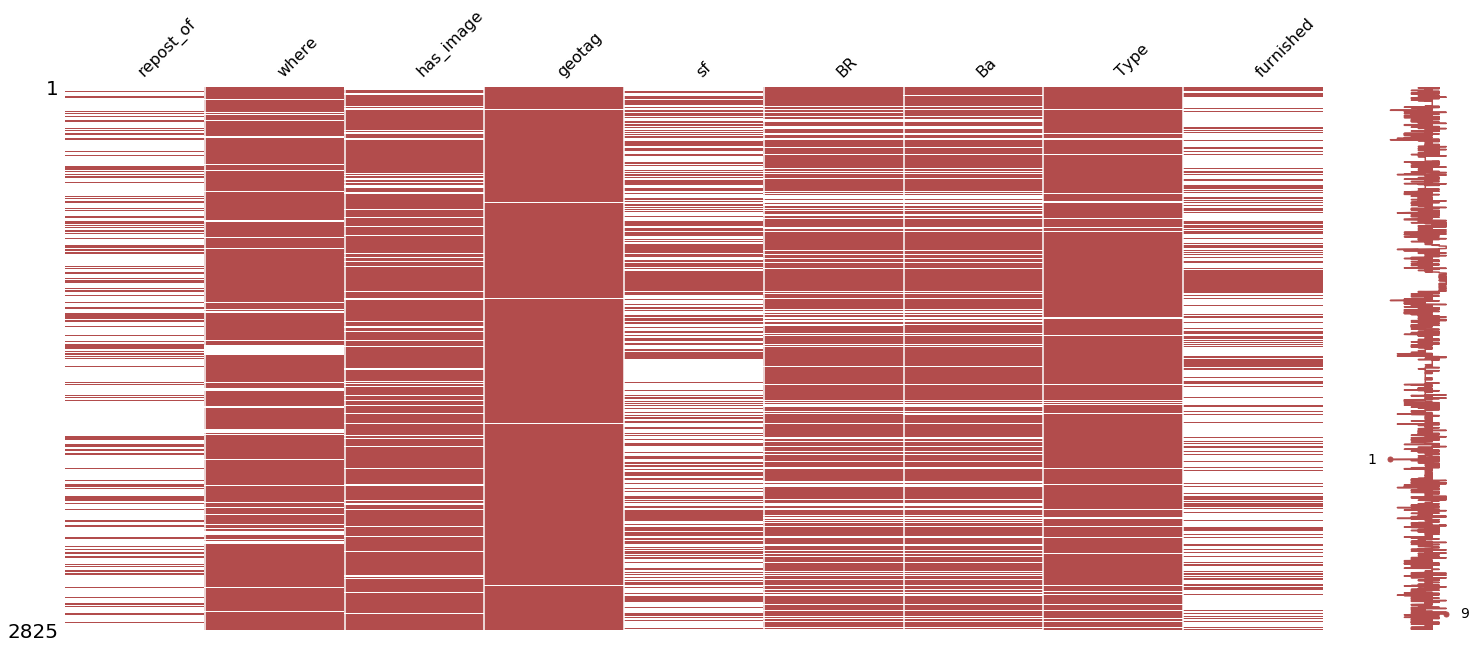

In [24]:
#Check for nan
missingdata_cols = DF.columns[DF.isnull().any()].to_list()
#visualize nan
_=missingno.matrix(DF[missingdata_cols], color=(0.7,0.3,0.3))


### Geocode the address to lat long

In [ ]:
#Dictionary with index and address
def geocode(addresses):
    #Input: a dictionary with key as index and value as address
    #Output: a dictionary with key as index and value as (lat, long) tuple
    lat_long = {}
    for index in addresses:
        try:
            url = geocode_api+f'?address={addresses[index]}'+f'&key={google_api}'
            url = re.sub(' +', '%20', url)
            response = requests.get(url)
            if response.ok:
                content = response.json()
                lat_long[index]=tuple(content['results'][0]['geometry']['location'].values())
            else:
                lat_long[index]=None
        except Exception as e:
            print(e)
            lat_long[index]=None
    return lat_long

In [ ]:
addresses = DF[DF['geotag'].isnull()]['where'].to_dict()

```lat_long = geocode(addresses)```

In [ ]:
#lat_long = geocode(addresses)

In [ ]:
## Replace the Null geocodes with the geocodes retrieved from the address
DF.loc[lat_long.keys(), 'geotag'] = DF.loc[lat_long.keys()].index.map(lat_long)

In [ ]:
#Now no missing values in geocode
#Check for nan
missingdata_cols = DF.columns[DF.isnull().any()].to_list()
missingdata_cols

### Postal codes based on lat long

In [ ]:
#https://maps.googleapis.com/maps/api/geocode/json?latlng=40.714224,-73.961452&key=YOUR_API_KEY
#reverse_geocode_api = 'https://maps.googleapis.com/maps/api/geocode/json'

#Dictionary with index and address
def reverse_geocode(loc):
    #Input: tuple - (lat, long)
    #Output: string - Postal Code
    lat, long = loc
    postal_code = None
    try:
        url = reverse_geocode_api+f'?latlng={lat},{long}&result_type=postal_code'+f'&key={google_api}'
        url = re.sub(' +', '%20', url)
        #print(url)
        response = requests.get(url)
        if response.ok:
            content = response.json()
            postal_code = content['results'][0]["address_components"][0]['long_name'] if 'postal_code' in content['results'][0]\
["address_components"][0]['types'] else None
    except Exception as e:
        print(e)
    return postal_code   

In [ ]:
#DF['postal_code'] = DF['geotag'].map(lambda x: reverse_geocode(x))
#DF[DF['postal_code'].notnull()].shape
#DF.shape
#Discarding those 6 items which doesn't have postal code
#DF.drop(index=DF[DF['postal_code'].isnull()].index, inplace=True)

``DF['postal_code'] = DF['geotag'].map(lambda x: reverse_geocode(x))``

``DF[DF['postal_code'].notnull()].shape``

``DF.shape``

``#Discarding those 7 items which doesn't have postal code``

``DF.drop(index=DF[DF['postal_code'].isnull()].index, inplace=True)``

In [ ]:
## Some Florida postal codes in the dataset. Remove them
#DF['postal_code'][DF['postal_code'].map(lambda x : re.findall('^[\d].*', x)[0] if re.findall('^[\d].*', x) else None).notnull()]  


In [ ]:
Florida_Zipcodes = DF['postal_code'][DF['postal_code'].map(lambda x : re.findall('^[\d].*', x)[0] if re.findall('^[\d].*', x) else None).notnull()].index    
#DF.drop(index=Florida_Zipcodes, inplace=True)

### Save standalone craigslist dataset

In [ ]:
#with open(os.path.join('..','Stage','craiglist_standalone.pkl'), 'wb') as f:
    #pickle.dump(DF, f)

In [25]:
with open(os.path.join('..','Stage','craiglist_standalone.pkl'), 'rb') as f:
    DF = pickle.load(f)

### Toronto postal codes

In [26]:
postal_code_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

In [27]:
postal_code_data = postal_code_data[postal_code_data['Borough'].map(lambda x: None if not re.findall('toronto', x, flags=re.IGNORECASE) else re.findall('toronto', x, flags=re.IGNORECASE)[0]).notnull()]
tor_postal_codes=postal_code_data['Postal Code'].to_list()

### Filter rental data based on postal code to extract just Toronto area (Initial data set has greater toronto area)

In [28]:
DF['Toronto'] = DF['postal_code'].map(lambda x: 'Toronto' if x.split()[0] in tor_postal_codes else None)

In [29]:
craiglist_toronto = DF[DF['Toronto'].notnull()].copy()
craiglist_toronto.drop('Toronto', axis=1, inplace=True)

# Connect tables Housing and crime data meaningfully!

- **``We need to have a bridge table``**
- **``Bridge table connects the rental data to the crime data based the crime locations within 3 kms of the rental location``**
- **``This logic is built using harvesine distance, which is the over the earth distance between two points``**
- **``The distance function is written separately and imported``**

In [30]:
def be_the_bridge(DF, crime_data, radius=3):
    
    bridge = pd.DataFrame()
    for row in tqdm(DF.iterrows()):
        try:
            
            loc = row[1]['geotag']
            result=crime_data[['Lat', 'Long']].apply(lambda x: (harvesine_distance(loc, (x['Lat'], x['Long'])) if harvesine_distance(loc, (x['Lat'], x['Long'])) <=radius else None), axis=1)
            result=pd.DataFrame(result[result.notnull()], columns=['distance'])
            closest_crimes=pd.concat([crime_data.loc[result.index, 'ID'], result], axis=1)
            closest_crimes['rental_id'] = row[1]['id']
            closest_crimes.rename({'ID':'crime_id'})

            bridge=pd.concat([bridge, closest_crimes])
        
        except:
            print(row[0])
            
    return bridge

In [31]:
#bridge = be_the_bridge(DF, crime_data, radius=3)

``with open(os.path.join('..','Stage','bridge_table_craigslist.pkl'), 'wb') as f:
     pickle.dump(bridge, f)``

In [32]:
with open(os.path.join('..','Stage','bridge_table_craigslist.pkl'), 'rb') as f:
     bridge_table = pickle.load(f)
        

### Tranformation required to append the craigslist table with kijii table

- **``We need to concatenate craigslist table with kijiji table``**
- **``All the column names have to be unique``**

In [33]:
def clean_rental_for_merge(df):
    DF= df.copy()
    #To rename
    DF.rename(columns={"has_image":"image", "name":"title", "datetime":"post_published_date", "where":"address", "Type":"rental_type", "BR":"bedrooms", "Ba":"bathrooms", "sf":"sqft", "text":"description"}, inplace=True)              
    #To extract
    DF['pet_friendly'] = DF.apply(lambda x: x['cats_allowed'] | x['dogs_allowed'], axis=1)
    DF['lat'] = DF.geotag.map(lambda x: float(x[0]))
    DF['long'] = DF.geotag.map(lambda x: float(x[1]))
    #To clean
    DF['price'] = DF['price'].map(lambda x: re.sub('[^\d]', '',x))
    #To drop
    DF.drop(["repost_of", "deleted", "apartment_feature", "cats_allowed", "dogs_allowed", "geotag", "posting", "attributes", "last_updated"], axis=1, inplace=True)
    #Add one source column
    DF['source'] = 'craigslist'
    #FSA
    DF['FSA']=DF['postal_code'].map(lambda x:x.split(' ')[0])
    #Reorder
    DF = DF[['id', 'title', 'price', 'sqft','image','url','post_published_date', 'lat', 'long', 'postal_code', 'FSA', 'rental_type','bedrooms', 'bathrooms', 'furnished', 'pet_friendly', 'description', 'source']]
    #Append c_ to the index
    DF['id'] = DF['id'].map(lambda x: 'c_'+str(x))
    #Change date
    DF.post_published_date = DF.post_published_date.map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M").strftime("%Y-%m-%d"))
    
    return DF
    

In [34]:
DF = clean_rental_for_merge(DF)

In [35]:
def clean_bridge_for_merge(df):
    DF = df.copy()
    DF.reset_index(drop=True, inplace=True)
    DF.reset_index(inplace=True)
    DF.columns= ['id', 'crime_id', 'distance_rental_crime', 'rental_id']
    DF = DF[['id', 'crime_id', 'rental_id', 'distance_rental_crime']]
    DF['rental_id'] = DF['rental_id'].map(lambda x: 'c_'+str(x))
    return DF

In [36]:
bridge_table = clean_bridge_for_merge(bridge_table)

### Tranformation required to add crime table

In [37]:
def clean_crime_data_for_load(df):
    DF = df.copy()
    #To rename
    DF.rename(columns={"ID":"id", "Lat":"lat", "Long":"long", "Division":"division", "Neighbourhood":"neighbourhood"}, inplace=True)
    DF=DF[['id', 'lat', 'long', 'occurrencedate', 'reporteddate', 'premisetype', 'offence', 'MCI',
       'division', 'neighbourhood']]
    return DF

In [38]:
crime_data = clean_crime_data_for_load(crime_data)

In [39]:
bridge_table.head()

id  crime_id     rental_id  distance_rental_crime
0   0         1  c_7175656775               2.949897
1   1        27  c_7175656775               2.671067
2   2        36  c_7175656775               2.810086
3   3        38  c_7175656775               2.961821
4   4        39  c_7175656775               2.961821

In [40]:
crime_data.head()

id        lat       long occurrencedate reporteddate premisetype  \
0   0  43.665787 -79.320106     2019-01-01   2019-01-01  Commercial   
1   1  43.763969 -79.204781     2019-01-01   2019-05-06   Apartment   
2   2  43.758972 -79.197578     2019-01-01   2019-02-01  Commercial   
3   3  43.739082 -79.592819     2019-01-01   2019-04-27   Apartment   
4   4  43.639343 -79.451309     2019-01-01   2019-04-26     Outside   

               offence      MCI division  \
0  Assault With Weapon  Assault      D55   
1              Assault  Assault      D43   
2              Assault  Assault      D43   
3              Assault  Assault      D23   
4              Assault  Assault      D11   

                           neighbourhood  
0                 Greenwood-Coxwell (65)  
1                           Woburn (137)  
2                        West Hill (136)  
3  Mount Olive-Silverstone-Jamestown (2)  
4                 High Park-Swansea (87)

In [41]:
DF.head()

id                                              title price  \
0  c_7175656775  2 Bedrooms Apartment for Rent - 1350 Danforth ...  1350   
1  c_7175641724        ☎2 Room+Separate Reception @Etobicoke/Miss☎  1599   
2  c_7175652366                     87 Peter - Slate - 1bed Sept 1  2000   
3  c_7175652126  Harbour Plaza! 1Bed/1Bath +media area - September  2250   
4  c_7175651860                     The Eglinton / Redpath -studio  1750   

    sqft                                              image  \
0    NaN  https://images.craigslist.org/00F0F_l6VTmsBVGh...   
1    NaN  https://images.craigslist.org/00q0q_hhCvFpP61t...   
2  538.0  https://images.craigslist.org/01212_1tx3p0rlYW...   
3  595.0  https://images.craigslist.org/00Q0Q_huAI9VgN8a...   
4  359.0  https://images.craigslist.org/00J0J_3SYJ5EqHxl...   

                                                 url post_published_date  \
0  https://toronto.craigslist.org/tor/apa/d/scarb...          2020-08-11   
1  https://toronto.craigslist.org/tor/off/d/2-roo...          2020-08-11   
2  https://toronto.craigslist.org/tor/apa/d/toron...          2020-08-11   
3  https://toronto.craigslist.org/tor/apa/d/toron...          2020-08-11   
4  https://toronto.craigslist.org/tor/apa/d/toron...          2020-08-11   

         lat       long postal_code  FSA rental_type  bedrooms  bathrooms  \
0  43.746400 -79.232300     M1J 2V3  M1J       house       2.0        1.0   
1  43.663625 -79.593099     L4W 4P2  L4W       suite       NaN        NaN   
2  43.646603 -79.392271     M5V 2G4  M5V       condo       1.0        1.0   
3  43.641093 -79.380324         M5J  M5J       condo       1.0        1.0   
4  43.707766 -79.392611     M4P 1J5  M4P       condo       1.0        2.0   

  furnished  pet_friendly                                        description  \
0      True          True  2BR / 1Ba cats are OK - purrr dogs are OK - wo...   
1      True         False   *SPECIAL OFFER - $200 off the monthly rent fo...   
2      None          True  1BR / 1Ba 538ft2 available sep 1 cats are OK -...   
3      None         False  1BR / 1Ba 595ft2 available sep 1 condo w/d in ...   
4      None         False  1BR / 2Ba 359ft2 available aug 14 condo w/d in...   

       source  
0  craigslist  
1  craigslist  
2  craigslist  
3  craigslist  
4  craigslist

In [54]:
crime_data

id        lat       long occurrencedate reporteddate premisetype  \
0          0  43.665787 -79.320106     2019-01-01   2019-01-01  Commercial   
1          1  43.763969 -79.204781     2019-01-01   2019-05-06   Apartment   
2          2  43.758972 -79.197578     2019-01-01   2019-02-01  Commercial   
3          3  43.739082 -79.592819     2019-01-01   2019-04-27   Apartment   
4          4  43.639343 -79.451309     2019-01-01   2019-04-26     Outside   
...      ...        ...        ...            ...          ...         ...   
37747  37747  43.768410 -79.186226     2019-12-31   2019-12-31     Outside   
37748  37748  43.768410 -79.186226     2019-12-31   2019-12-31     Outside   
37749  37749  43.654526 -79.369461     2019-12-31   2019-12-31   Apartment   
37750  37750  43.730927 -79.458641     2019-12-31   2019-12-31  Commercial   
37751  37751  43.757614 -79.515366     2019-12-31   2019-12-31     Outside   

                   offence              MCI division  \
0      Assault With Weapon          Assault      D55   
1                  Assault          Assault      D43   
2                  Assault          Assault      D43   
3                  Assault          Assault      D23   
4                  Assault          Assault      D11   
...                    ...              ...      ...   
37747  Assault Bodily Harm          Assault      D43   
37748      Robbery - Other          Robbery      D43   
37749                  B&E  Break and Enter      D51   
37750                  B&E  Break and Enter      D32   
37751  Assault With Weapon          Assault      D31   

                               neighbourhood  
0                     Greenwood-Coxwell (65)  
1                               Woburn (137)  
2                            West Hill (136)  
3      Mount Olive-Silverstone-Jamestown (2)  
4                     High Park-Swansea (87)  
...                                      ...  
37747                        West Hill (136)  
37748                        West Hill (136)  
37749                         Moss Park (73)  
37750              Downsview-Roding-CFB (26)  
37751            Glenfield-Jane Heights (25)  

[37752 rows x 10 columns]

In [49]:
DF=DF[DF['FSA'].isin(set(postal_code_data['Postal Code']))]

## Save all dataframes as csv

In [51]:
DF.to_csv(os.path.join('..','Output','Rental_Craigslist.csv'), index=False)
#crime_data.to_csv(os.path.join('..','Output','Crime.csv'), index=False)
#bridge_table.to_csv(os.path.join('..','Output','Bridge_Rental_Crime_Craigslist.csv'), index=False)